In [0]:
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.2);
sns.set_style("whitegrid");

In [0]:
###util methods
from matplotlib.colors import ListedColormap
from sklearn import metrics
def plot_decision_boundary(clf,X,y):
  cols = X.columns.values
  X = X.values
  y = y.values
  cm = plt.cm.brg	
  cm_bright = ListedColormap([ '#0000FF','#FF8C00'])
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
  					 np.arange(y_min, y_max, 0.2))
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(12,12))
  plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
  plt.title("accuracy=%.2f"%(clf.score(X,y)))
  plt.xlabel(cols[0])
  plt.ylabel(cols[1])
def plot_regression_degree(dataset,model,true_fun,degrees):	
	nrows  = len(degrees)/2.
	if int(nrows) < nrows:
		nrows = int(nrows)+1
	else:
		nrows = int(nrows)
	plt.figure(figsize=(12, 4*nrows))
	for i,d in enumerate(degrees):
		plt.subplot(nrows, 2, i+1)
		plt.subplots_adjust(hspace=.5)
		X = dataset.copy()
		X_test = pd.DataFrame(np.linspace(0, 1, 100),columns=['x1'])
		y = X.pop('y')
		for j in range(2,d+1):
			X['x1^'+str(j)] = X['x1']**j
			X_test['x1^'+str(j)] = X_test['x1']**j
		model.fit(X, y)
		pred = model.predict(X)
		pred_test = model.predict(X_test)
		plt.plot(X_test['x1'], pred_test, label="Model",lw=3)
		plt.plot(X_test['x1'], true_fun(X_test['x1']), label="True function")
		plt.scatter(X['x1'], y, label="Samples")
		plt.xlabel("x1")
		plt.ylabel("y")
		plt.xlim((0, 1))
		plt.ylim((-2, 6))
		if i == 0: plt.legend(loc="upper right")
		plt.title("degree %d (%.3f)" % (d,metrics.r2_score(y,pred)))
	plt.show()
def plot_coefs(lambdas,coefs):
	ax = plt.gca()
	ax.set_prop_cycle('color',['b', 'r', 'g', 'c', 'k', 'y', 'm'])
	ax.plot(lambdas, coefs)
	lineObjects = ax.plot(lambdas, coefs)
	ax.set_xscale('log')	
	plt.legend(iter(lineObjects),[r"$\theta_{" + s + "}$" for s in map(str,range(1,13))])	
	plt.xlabel(r'$\lambda$')
	plt.ylabel(r'$\theta$')	  

# 4. Regularization

Real world data sets suffer from many shortcomings. The most important one is the presence of **noise**, which manifests itself at different levels:

- **noise in the feature values**: the true (underlying) feature values differ from the observed values in the data sets. This is typically the case happens when feature values are obtained from measuring devices such as microarrays or mass spectrometers.

- **label noise**: the true underlying target or label for a data point is different from the one observed in the data set. This happens for instance when a data set is manually labeled by a field expert (e.g. for the recognition of malignant melanoma). The expert can be wrong for some of the samples. Also, different experts may judge samples differently. 

- **redundant** or **irrelevant** features: redundant features are those which provide no more information than other features in the data set, and irrelevant features provide no useful information for the prediction task.

In the **presence of noise the model should not try to fit the data perfectly**. If it does it will be fitting the noise (as we have seen in the chapter about model selection). Similarly, **if we are not sure all features are relevant, the model should not try to use all features**. 

Let's illustrate this with a simple polynomial regression example. We will generate a data set that contains 30 data points that were randomly sampled from the function $f(x)=\cos(1.5\pi x)$. Next we add random noise to the target and make polynomial data transformations of varying degrees. Finally we plot the resulting model fits:

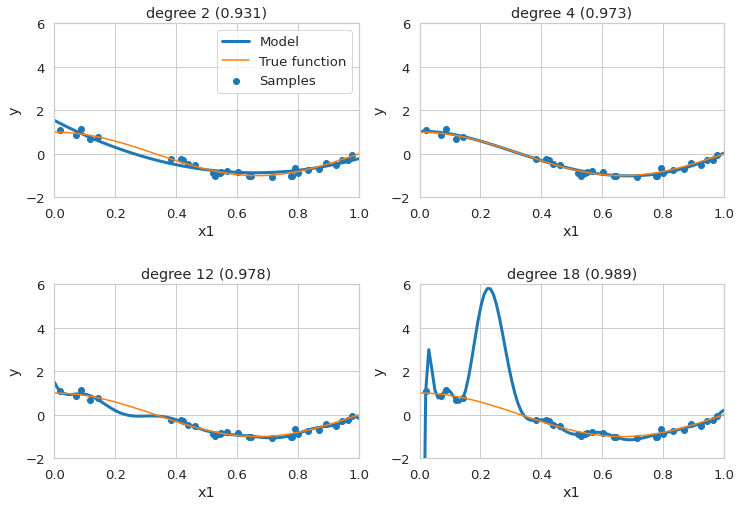

In [3]:
from sklearn.linear_model import LinearRegression

np.random.seed(0)

n_samples = 30

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

dataset_reg = pd.DataFrame()
dataset_reg['x1'] = np.sort(np.random.rand(n_samples))
dataset_reg['y'] = true_fun(dataset_reg['x1']) + np.random.randn(n_samples) * 0.1 #adding noise

model_reg = LinearRegression()
plot_regression_degree(dataset_reg,model_reg,true_fun,[2, 4, 12, 18])

For each plot the polynomial degree of the model as well as $R^2$ is shown in the title. 

We observe how $R^2$ becomes better when we increase the degree of the polynomial, i.e. when we increase the complexity of the model. However we can also observe very clearly how the complex models start to fit the noise in the data set and deviate strongly from the true function that generated the data (green curve).

In the chapter about model selection we have seen how we can avoid overfitting the degree $d$: use $k$-fold CV to create validation sets and decide on the opimal value for $d$ using the predictions on these validation sets (and ultimately also on the test set). 

By searching for the optimal value for $d$ using CV we are actually trying to control the **complexity** of the model such that it performs well on both the train **and** the validation set. As the validation set mimics the test set we can expect best generalization performance for the optimal value of $d$ obtained on this validation set.

Controlling the complexity of the model applies to all machine learning algorithms. This was the data set used in the notebook about logistic regression:

<Figure size 864x864 with 0 Axes>

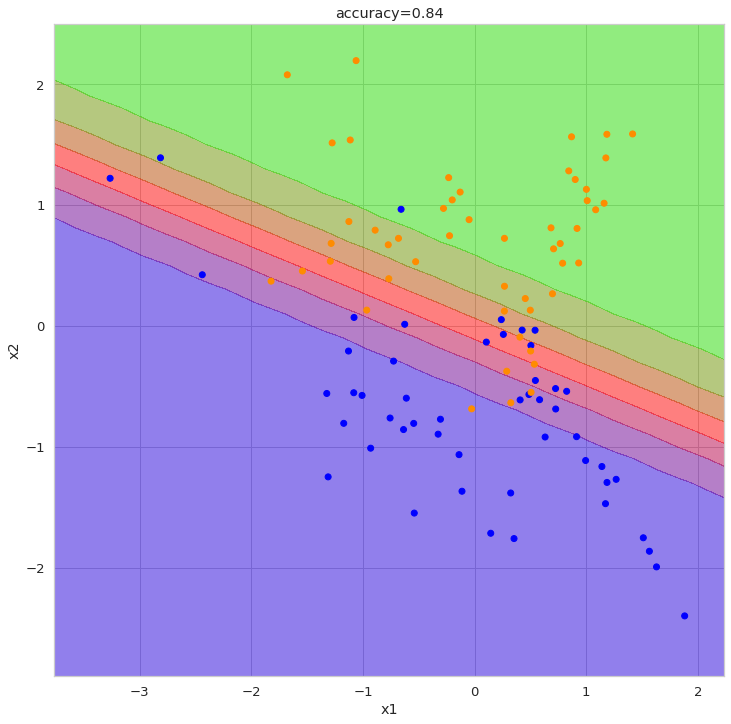

In [4]:
from sklearn.linear_model import LogisticRegression

dataset_clf = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/3_logistic_regression/dataset2D.csv")

X = dataset_clf.copy()
y = X.pop('y')
model_clf = LogisticRegression(C=10000)
model_clf.fit(X,y)

plt.figure(figsize=(12,12))
plot_decision_boundary(model_clf,X,y)
plt.show()

This data can never be separated with 100% accuracy using a linear model. In this case the accuracy on the train set is 84%. However, we can again add polynomial transformations of the features to obtain better classification accuracy on the train set. As we have two features $x_1$ and $x_2$ the polynomial features of degree 2 added to the data set are $x_1^2$, $x_1x_2$ and $x_2^2$. We can compute these polynomial features easily with the `PolynomialFeatures` module in the `sklearn.preprocessing` package:

<Figure size 864x864 with 0 Axes>

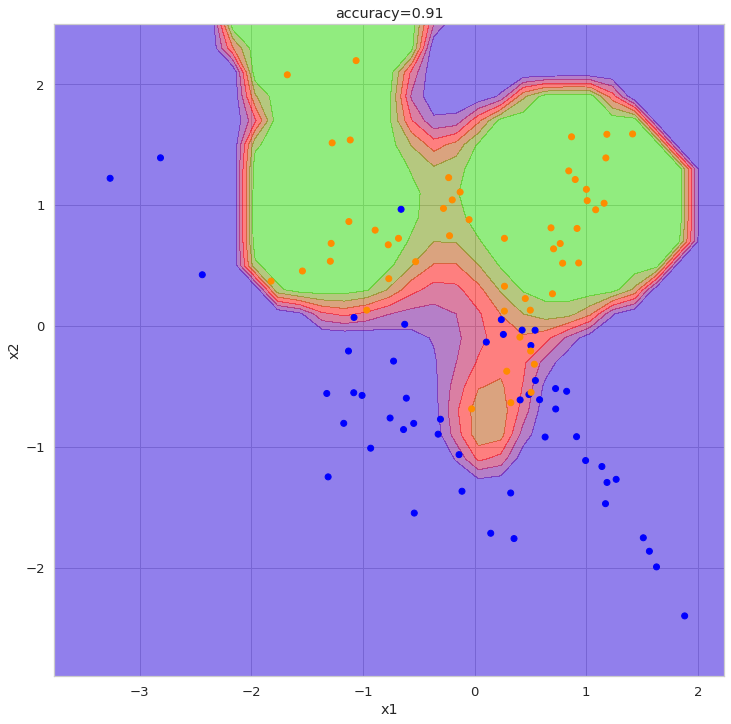

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()

clf = LogisticRegression(C=1000000)
polynomial_features = PolynomialFeatures(degree=7)
model_pipeline = Pipeline([("polynomial_features", polynomial_features),
                           ("MinMaxScaler", feature_scaler),
                         ("logistic_regression", clf)])

model_pipeline.fit(X,y)

plt.figure(figsize=(12,12))
plot_decision_boundary(model_pipeline,X,y)
plt.show()

In this case the train set accuracy is much better at 91%. However, as with the example of regression discussed above we can again observe that this fit with a polynomial of degree 7 might be far from the true model that generated the data. Again we seem to overfit the possible noise in the data set.

The idea behind **model regularization** is to find a balance between the complexity of the model (e.g. the degree of the polynomial) and the ability of the model to fit the data accurately. Indeed the linear fit shown for the regression task discussed above lacks the complexity (or flexibility) to model the data correctly. 

A more complex model of degree 4 is required. However, for even more complex models such as degree 18 the model starts to overfit the noise in the data. So this model is too complex. This means that we have to **regulate the complexity of the model**: make sure the complexity is sufficient to learn the true model that generated the data, but not more complex than that.

Mathematically we can formalize **regularization** as an additional term to the cost function of the learning algorithm. 

For regularized linear regression we use the cost function

$$ J(\theta)=\frac{1}{2n}\sum\limits_{i=1}^n(f(x^{(i)},\theta) - y^{(i)})^2 + \lambda \sum\limits_{j=1}^{m}\theta_j^2.$$

The term added to the cost function of linear regression is $\lambda \sum\limits_{j=1}^{n}\theta_j^2$, i.e. the sum of the squared weights multiplied by $\lambda$. 

Minimizing the cost function $J(\theta)$ thus means minimizing the magnitude of the errors made on the data set while minimizing also the complexity of the model (i.e. small values for $\theta$, preferably zero). The contribution of the model complexity to the cost function is then controlled by **hyperparameter** $\lambda\geq0$, which is typically optimized using cross-validation. For **regularized linear regression** (or **Ridge regression**) the updates computed during the gradient descent iterations are 

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)},$$

and for $j=1 \ldots m$

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}-\frac{\lambda}{m}\theta_j,$$

with 

$$f(x,\theta)=\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m.$$

For **regularized logistic regression** the cost function becomes

$$J(\theta)=-[\frac{1}{n}\sum\limits_{i=1}^ny^{(i)}log(f(x^{(i)},\theta))+(1-y^{(i)})log(1- f(x^{(i)},\theta))]+\frac{\lambda}{2m}\sum\limits_{j=1}^{m}\theta^2,$$

where $\lambda\geq0$ is again a model parameter that controls the balance between model training set accuracy and model complexity and is again set by the user. The updates computed during the gradient descent iterations are now

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)},$$

and for $j=1 \ldots m$

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}-\frac{\lambda}{m}\theta_j,$$

with

$$f(x,\theta)=g(\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m).$$

The regularized linear regression algorithm is implemented as the `Ridge` module in scikit-learn. Here we create a Ridge model with $\lambda=0.001$ (note the $\lambda$ is provided as function parameter *alpha*).

In [0]:
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=0.001)

Now we can copy the code we used for the regression data set discussed above and replace the `LinearRegression` object by the `Ridge` object.

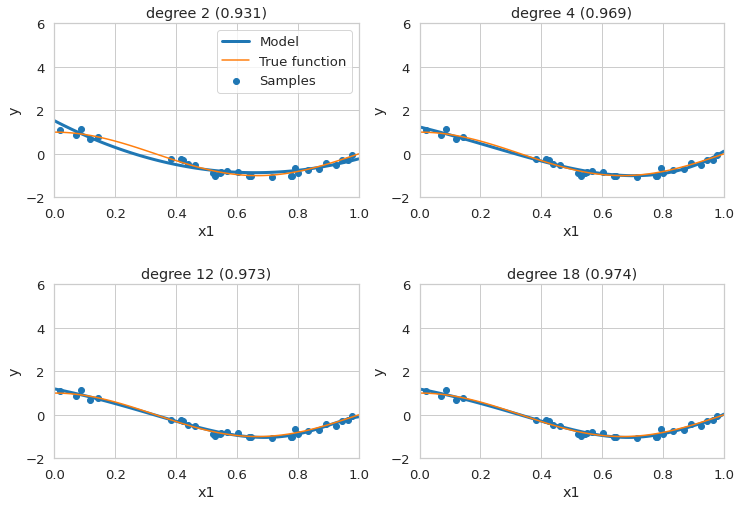

In [7]:
plot_regression_degree(dataset_reg,model_ridge,true_fun,[2, 4, 12, 18])

Observe how the complexity of the model is controlled for the larger polynomial degrees. Let's take a look at the optimal model parameter values $\theta$ for the polynomial model of degree 12 when $\lambda=0.001$:

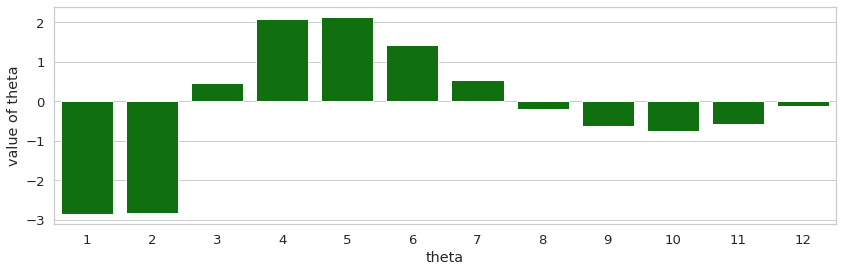

In [8]:
degree = 12

X = dataset_reg.copy()
y = X.pop('y')
for j in range(2,degree+1):
    X['x1^'+str(j)] = X['x1']**j

model_ridge.fit(X,y)
coefs = model_ridge.coef_

model_parameters = pd.DataFrame()
model_parameters['theta'] = range(1,len(coefs)+1)
model_parameters['value of theta'] = coefs

plt.figure(figsize=(14,4))
sns.barplot(x='theta',y='value of theta',data=model_parameters,color='g')
plt.show()

If we set $\lambda=0$, i.e. we remove the regularization term, we get the overfitting again:

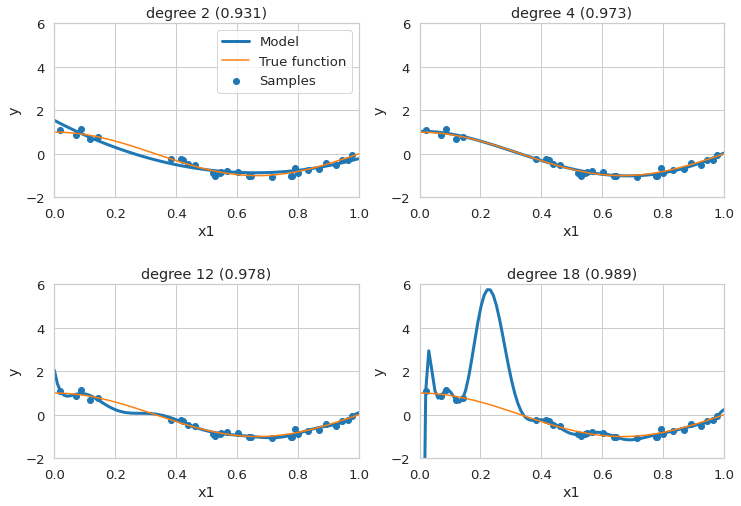

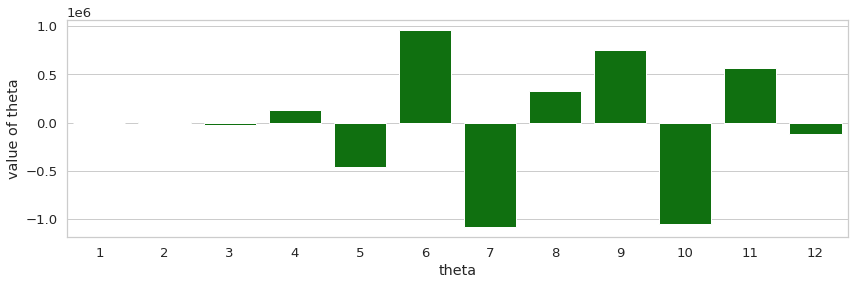

In [9]:
model_ridge = Ridge(alpha=0)

plot_regression_degree(dataset_reg,model_ridge,true_fun,[2, 4, 12, 18])

model_ridge.fit(X,y)
coefs = model_ridge.coef_

model_parameters = pd.DataFrame()
model_parameters['theta'] = range(1,len(coefs)+1)
model_parameters['value of theta'] = coefs

plt.figure(figsize=(14,4))
sns.barplot(x='theta',y='value of theta',data=model_parameters,color='g')
plt.show()

We can see that the values for $\theta$ are much larger now and much more weight is assigned to the higher degree polynomial features.  This made it possible to fit more complex models that are able to fit the noise well. Regularization is thus closely related to the nature of the noise in the data set. Regularization is also related to the relative size of the dataset. Data sets with many features and few samples are common in machine learning and are easy to overfit. Regularization helps significantly to deal with these **sparse high-dimensional** data sets. 

For now we have chosen $\lambda=0.001$ as a good regulator. Let's consider other values for $\lambda$ and see how they affect the model parameters and the fit. 

We fit different Ridge models (with different values for $\lambda$) to the data and plot the optimal values for $\theta$ against $\lambda$. Each model parameter $\theta_j$ is represented by a color: 

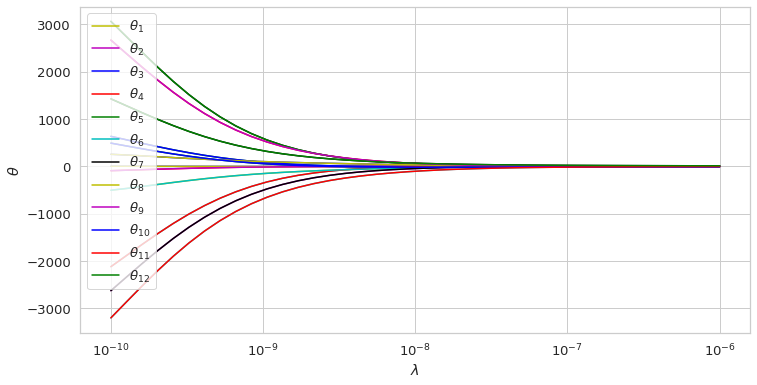

In [10]:
n_lambda = 40
lambdas = np.logspace(-6, -10, n_lambda)

model_ridge = Ridge()

coefs = []
for l in lambdas:
    model_ridge.set_params(alpha=l)
    model_ridge.fit(X, y)
    coefs.append(model_ridge.coef_)

plt.figure(figsize=(12,6))
plot_coefs(lambdas,coefs)
plt.show()    

The plot shows how larger values for $\lambda$ constrain the values the model parameters can have.

For regularized logistic regression we reconsider the artificial data set we created above and fit a regularized logistic regression model to the data augmented with polynomial features of degree 7. We use the `LogisticRegression` module from scikit-learn that is in fact already an implementation of regularized logistic regression controlled by the function parameter $C$. However in the implementation $C$ = $1/\lambda$ and can be seen as the cost paid for a misclassification. Larger values for $C$ will allow for more complex models. This is why for the example above we set $C$=100000 to allow for maximum model complexity, which mimics unregularized logistic regression. In the example shown below we decrease $C$ to 1, i.e. we lower the complexity of the model:

<Figure size 864x864 with 0 Axes>

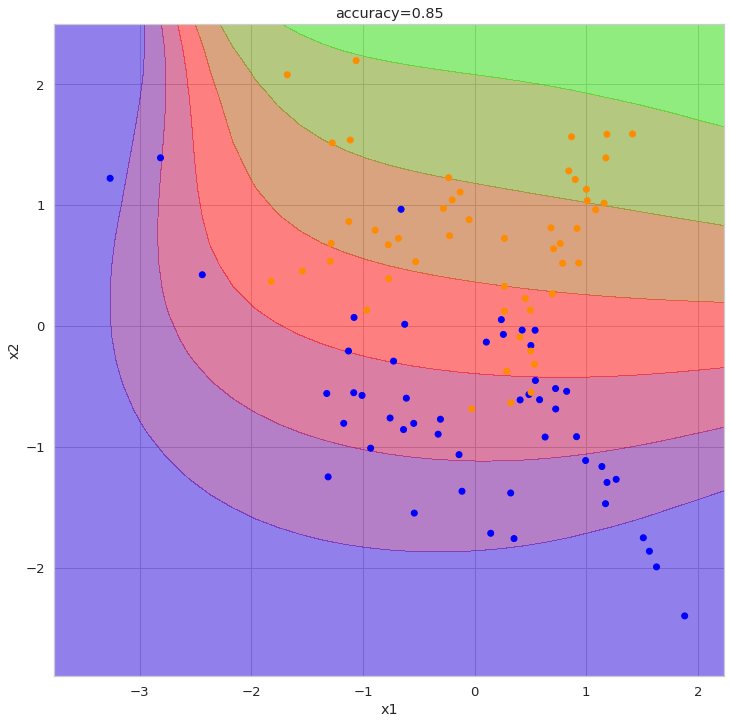

In [11]:
X = dataset_clf.copy()
y = X.pop('y')

clf = LogisticRegression(C=1)
polynomial_features = PolynomialFeatures(degree=7)
model_pipeline = Pipeline([("polynomial_features", polynomial_features),
                           ("MinMaxScaler", feature_scaler),
                         ("logistic_regression", clf)])

model_pipeline.fit(X,y)

plt.figure(figsize=(12,12))
plot_decision_boundary(model_pipeline,X,y)
plt.show()

We now have a means to control the complexity of the model learned from the train set by setting the value of a hyperparameter that controls the **balance between train set accuracy and model complexity**. We want to find the value for this hyperparameter that allows for training a model that performs best on unseen external data. We can (or should) thus apply a cross-validation loop to compute the optimal value for the hyperparameter using a validation set as we have seen in the chapter about model selection and validation. 

In scikit-learn there is a package `sklearn.grid_search` that contains the `GridSearchCV` module. This module performs cross-validation to find the best hyperparameter combination from a set of candidate hyperparamter values with a minimal of coding:

In [12]:
from sklearn.model_selection import GridSearchCV

search_space = np.logspace(-10, 18, 10, base=2)

params = dict(logistic_regression__C=search_space)
grid_search = GridSearchCV(model_pipeline, param_grid=params)
grid_search.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomial_features',
                                        PolynomialFeatures(degree=7,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('MinMaxScaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('logistic_regression',
                                        LogisticRegression(C=1,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,

To view the result of the hyperparameter optimization procedure we can use the following code:

In [13]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean_score, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("{:.3f} (+/-{:.3f}) for {}".format(mean_score, std * 2, params))

0.820 (+/-0.206) for {'logistic_regression__C': 0.0009765625}
0.830 (+/-0.224) for {'logistic_regression__C': 0.00843796671009614}
0.840 (+/-0.194) for {'logistic_regression__C': 0.0729080649735073}
0.850 (+/-0.110) for {'logistic_regression__C': 0.6299605249474368}
0.860 (+/-0.160) for {'logistic_regression__C': 5.4431600006975085}
0.870 (+/-0.162) for {'logistic_regression__C': 47.031503752819155}
0.840 (+/-0.147) for {'logistic_regression__C': 406.3746693038594}
0.850 (+/-0.126) for {'logistic_regression__C': 3511.2713537661884}
0.840 (+/-0.117) for {'logistic_regression__C': 30339.06257222994}
0.850 (+/-0.155) for {'logistic_regression__C': 262144.0}


We see that the CV performance is optimal for values $C$ arround 50. In this case the average accuracy on the validation sets is 94.2%. However, we cannot consider this accuracy as a performance evaluation of a model with $C=50$. To estimate the performance on unseen external data we have to use an independent test set. However, as the data set is small, leaving out more data might produce unstable results that differ depending on which data points are selected for the test set. 

To solve this we use cross-validation to create the test set as well. By combining the cross_val_predict() and the GridSearchCV() methods of scikit-learn we can create what is know as a **nested cross-validation** loop to compute the predictions on a test set that contains all the data points in the data set:

In [0]:
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

params = dict(logistic_regression__C=search_space)
grid_search = GridSearchCV(model_pipeline, param_grid=params)

cv_predictions = cross_val_predict(grid_search, X, y, method="predict_proba")

From these predictions we can now compute an estimate of the generalization performance of our optimal model. Here for instance we compute the AUC:

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y, cv_predictions[:,1])
print(metrics.auc(fpr, tpr))

0.9412
